# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

In this project we will try to find an optimal location for a restaurant. Specifically, this report will be targeted to stakeholders interested in opening an **Vegan restaurant** in **Goiânia**, Brazil.

Since there aren't many vegan restaurants in Goiânia we will try to detect **locations that are mostly likely to receive well a new vegan restaurant** looking to places that alreary are this kind of restaurant and detecting similar neighborhoods. We are also particularly interested in **areas close to city center as possible**.

We will use our data science powers to generate a few most promissing neighborhoods based os this criteria. Advantages of each area will then be clearly expressed so that best possible final location can be chosen by stakeholders.

## Data <a name="data"></a>

Based on definition of our problem, factors that will influence our decision are:

* number of existing restaurantes in the neighborhood (any type of restaurant)
* number of Vegan restaurants int he neighborhood, if any
* similarity between neighborhoods
* distance of neighborhood form city center
    
Following data sources will be neede to extract/generate the required information:

* centers of candidate areas will be generated algoritmically and approximate addresses fo centers of those areas will be obtained using **Google Maps API reverse geocoding**
* number of restaurantes and their tpe and location in every neighborhood will be obtained using Foursquare API
* coordinate of Berlin center will be obtained using Google Maps API geocoding

### Neighborhood Candidates

1. Scraping the page [https://nominatim.openstreetmap.org/details.php?osmtype=R&osmid=334547&class=boundary] to importing Goiânia borough data
2. Pre-prosesing Borough data
3. Getting Borough data Coordinates
4. Pre-prosessing Coodinates data


#### 1. Scraping page to import Goiânia borough data

Importing necessary Libraries

In [1]:
from selenium import webdriver
from bs4 import BeautifulSoup
from selenium.webdriver.firefox.options import Options

import pandas as pd
import numpy as np

Scraping and cleaning the pages

In [2]:
   # Set the path to chromedriver
url = r"https://nominatim.openstreetmap.org/details.php?osmtype=R&osmid=334547&class=boundary"
    
driver = webdriver.Chrome(r"C:\Users\ErikaS\Documents\Projetos Érika\Coursera__Capstone/chromedriver")

    # Get the url
driver.get(url)

    # Select the div correct and extrating the table in html format
driver.find_element_by_xpath("/html/body/div[2]/div[3]/div/table").click()
element = driver.find_element_by_xpath("/html/body/div[2]/div[3]/div/table")
html_content = element.get_attribute('outerHTML')

    # Close the browser
driver.quit()
    
    # Tranforming
soup = BeautifulSoup(html_content, 'html.parser')
table = soup.find(name = 'table')

    # Using pandas to structure the table in a DataFrame
df_full = pd.read_html(str(table))[0]


In [3]:
df_full.head()

,Local name,Type,OSM,Address rank,Admin level,Distance,Unnamed: 6
0,Goiânia,boundary:administrative,relation 334547,16.0,8.0,0,details >
1,Microrregião de Goiânia,boundary:administrative,relation 4857379,14.0,7.0,0.1012,details >
2,Região Geográfica Intermediária de Goiânia,boundary:administrative,relation 4873222,10.0,5.0,0.8761,details >
3,Goiás,boundary:administrative(state),relation 334443,8.0,4.0,0.7385,details >
4,Região Centro-Oeste,boundary:administrative,relation 3359944,6.0,3.0,5.2385,details >


#### 2. Pre-prosesing Borough data

In [4]:
# Selecting only the borough
borough_gyn = df_full[df_full[ 'Address rank'] > 17.0] .sort_values("Local name")

# Selecting useful columns
borough_gyn = borough_gyn.loc[:, ['Local name', 'Distance']]

# Cleaning column Distance
borough_gyn['Distance'] = borough_gyn['Distance'].str.replace(" km", "").str.replace("~", "").str.replace(" m", "").astype(float)

# Excluding duplicate data 
borough_gyn = borough_gyn.groupby('Local name').max()
borough_gyn.reset_index(level=0, inplace=True)

borough_gyn.head()

,Local name,Distance
0,Aldeia do Vale,8.7
1,Alphaville Flamboyant Residencial Araguaia,3.8
2,Bairro Boa Vista,13.6
3,Bairro Capuava,6.6
4,Bairro Feliz,3.0


It's important to be clear that the Goiânia borough data provided by web scraping provided to us:

- **Local name:** The Borough names;
- **Distance:** The distance from city center

In [5]:
borough_gyn.shape

(333, 2)

Saving the data to use later

In [6]:
borough_gyn.to_csv("bairros_gyn.csv", index=False)

#### Importing Borough data

In [3]:
import pandas as pd
import numpy as np

borough_gyn = pd.read_csv("bairros_gyn.csv")

Now that we have all the Goiânia Boroughs, we can select only the boroughs that are in a radio of 10 km from the center city.


In [5]:
borough_candidates = borough_gyn[borough_gyn['Distance'] < 10]
print("Dimensions: ", borough_candidates.shape)
borough_candidates.head()

Dimensions:  (210, 2)


,Local name,Distance
0,Aldeia do Vale,8.7
1,Alphaville Flamboyant Residencial Araguaia,3.8
3,Bairro Capuava,6.6
4,Bairro Feliz,3.0
6,Bairro Santo Hilário,6.1


#### 2. Data coordinates

Importing libraries to get geocoordinates

In [4]:
#!pip install geopandas 
#!pip install geopy
import geopandas as gpd
import pandas as pd

Using Nominatim API to get the coordinates

Getting the center coordinate

In [5]:
# Center coordinate
center_goiania = gpd.tools.geocode(" Goiânia, GO", provider = 'nominatim', user_agent="imp geocode")
lat_gyn = center_goiania['geometry'][0].x
long_gyn = center_goiania['geometry'][0].y
print('Coordinate of Goiânia, GO", Brazil: [{} , {}]'.format(lat_gyn, long_gyn))

Coordinate of Goiânia, GO", Brazil: [-49.2532691 , -16.680882]


In [14]:
address = pd.DataFrame({"ende": borough_candidates['Local name'] + ", Goiânia, GO "})
borough_candidates["Geom"]  = gpd.tools.geocode(address["ende"], provider = 'nominatim', user_agent="imp geocode", country_bias = "Brazil")["geometry"]


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [15]:
borough_candidates.head()

,Local name,Distance,Geom
0,Aldeia do Vale,8.7,POINT (-49.19967 -16.60501)
1,Alphaville Flamboyant Residencial Araguaia,3.8,POINT (-49.21316 -16.69865)
3,Bairro Capuava,6.6,POINT (-49.32322 -16.65565)
4,Bairro Feliz,3.0,POINT (-49.22855 -16.66210)
6,Bairro Santo Hilário,6.1,POINT (-49.19548 -16.65080)


#### 4. Pre-prosessing Coodinates data

In [26]:
borough_candidates["Lat"] = borough_candidates['Geom'].map(lambda p: p.x)
borough_candidates["Long"] = borough_candidates['Geom'].map(lambda p: p.y)


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [27]:
borough_candidates.head()

,Local name,Distance,Geom,geometry,Lat,Long
0,Aldeia do Vale,8.7,POINT (-49.19967 -16.60501),POINT (-49.19967 -16.60501),-49.199667,-16.605009
1,Alphaville Flamboyant Residencial Araguaia,3.8,POINT (-49.21316 -16.69865),POINT (-49.21316 -16.69865),-49.213159,-16.698653
3,Bairro Capuava,6.6,POINT (-49.32322 -16.65565),POINT (-49.32322 -16.65565),-49.323221,-16.655652
4,Bairro Feliz,3.0,POINT (-49.22855 -16.66210),POINT (-49.22855 -16.66210),-49.228554,-16.662100
6,Bairro Santo Hilário,6.1,POINT (-49.19548 -16.65080),POINT (-49.19548 -16.65080),-49.195476,-16.650797


Saving the data to use later

In [29]:
borough_candidates.to_csv("borough_candidates.csv", index=False)

Importing the data

In [1]:
import pandas as pd
import numpy as np

borough_candidates = pd.read_csv("https://raw.githubusercontent.com/erikastats/Coursera__Capstone/master/borough_candidates.csv")


In [6]:
borough_candidates.head()

,Local name,Distance,Lat,Long
0,Aldeia do Vale,8.7,-49.199667,-16.605009
1,Alphaville Flamboyant Residencial Araguaia,3.8,-49.213159,-16.698653
2,Bairro Capuava,6.6,-49.323221,-16.655652
3,Bairro Feliz,3.0,-49.228554,-16.662100
4,Bairro Santo Hilário,6.1,-49.195476,-16.650797


Let's visualize the data we have so far: city center location and candidate neighborhood centers:

In [9]:
#!pip install folium
import folium


In [6]:
gyncoor = [long_gyn, lat_gyn]
gyncoor

[-16.680882, -49.2532691]

In [10]:
map_goiania = folium.Map(location=gyncoor, zoom_start=12)
folium.Marker([lat_gyn, long_gyn], popup='Goiania').add_to(map_goiania)
for lat, lon in zip(borough_candidates["Long"], borough_candidates['Lat']):
    folium.Circle([lat, lon], radius=100, color='blue', fill=False).add_to(map_goiania)

map_goiania

### Foursquare

Now that we have our location candidates, let's use Foursquare API to get info on restaurants in each neighborhood.

We're interested in venues in 'food' category, but only those that are proper restaurants - coffe shops, pizza places, bakeries etc. are not direct competitors so we don't care about those. So we will include in out list only venues that have 'restaurant' in category name, and we'll make sure to detect and include all the subcategories of specific 'Vegan restaurant' category, as we need info on Vegan restaurants in the neighborhood.

The credentials and Version are defined in hidden cell bellow


In [11]:
CLIENT_ID = 'DJRZXO3LNK3CFTC45R4Y100OKQLV010RFO455LMWYUQBWDKN' # your Foursquare ID
CLIENT_SECRET = 'U2D1AD452QTRPENFVKJCYQW15BVSJGLKAXYZ4VNTSTRPF4ZW' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [12]:
import requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

from sklearn.cluster import KMeans

Let's search for venues in the first neighborhood

In [38]:


neighborhood_latitude = borough_candidates.loc[0, 'Long'] # neighborhood latitude value
neighborhood_longitude = borough_candidates.loc[0, 'Lat'] # neighborhood longitude value

LIMIT = 100
#search_query = 'Marble Hill'
radius = 500

url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, 
                                                                                                                              CLIENT_SECRET, 
                                                                                                                              neighborhood_latitude, 
                                                                                                                              neighborhood_longitude, 
                                                                                                                              VERSION,  
                                                                                                                              radius, 
                                                                                                                              LIMIT)


#https://api.foursquare.com/v2/venues/client_id=******&client_secret =******&v=20180602&||=40.73,-74.01&query=coffee
results = requests.get(url).json()

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
    
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,drogasil,Pharmacy,-16.605659,-49.201679
1,Drop's,Nightclub,-16.604792,-49.201491


#### Repeat the same process to all the neighborhoods in Goiânia

Now we will repeat the process in all neighborhoods, but only with data about **food places**. The fuction that will be used to repeat the process

In [44]:
# Category IDs corresponding to Vegan restaurants were taken from Foursquare web site (https://developer.foursquare.com/docs/resources/categories):

food_category = '4d4b7105d754a06374d81259'

vegan_category = '4bf58dd8d48988d1d3941735'

LIMIT = 100

def getNearbyVenues(names, latitudes, longitudes, category, radius=400):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            category,
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [14]:
goiania_venues = getNearbyVenues(names= borough_candidates['Local name'],
                                   latitudes= borough_candidates['Long'],
                                   longitudes= borough_candidates['Lat'],
                                category = food_category, radius=700
                                  )


In [47]:
goiania_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Aldeia do Vale,-16.605009,-49.199667,Master Gril Refeições,-16.598503,-49.203251,Brazilian Restaurant
1,Aldeia do Vale,-16.605009,-49.199667,Jantinha Da Baiana,-16.599730,-49.206406,Restaurant
2,Aldeia do Vale,-16.605009,-49.199667,Panificafora Modelo,-16.599608,-49.206724,Bakery
3,Alphaville Flamboyant Residencial Araguaia,-16.698653,-49.213159,Panificadora Skina do Pão,-16.692809,-49.212366,Bakery
4,Alphaville Flamboyant Residencial Araguaia,-16.698653,-49.213159,Megaburger's,-16.694582,-49.213653,Fast Food Restaurant


Let's check how many food places were returned for each neighborhood

In [15]:
goiania_venues.groupby('Neighborhood', as_index = False)['Venue'].count().sort_values(by = ['Venue'], ascending = False).head(10)

,Neighborhood,Venue
141,Setor Marista,91
134,Setor Bela Vista,74
148,Setor Nova Suiça,62
129,Serrinha,60
131,Setor Alto da Glória,59
152,Setor Pedro Ludovico,55
151,Setor Oeste,54
183,Vila Redenção,51
136,Setor Campinas,43
67,Loteamento Mansões Goianas,41


Let's find out how many unique categories can be curated from all the returned venues and how many venues was returned

In [16]:
print('There are {} uniques categories.'.format(len(goiania_venues['Venue Category'].unique())))
print('There are {} venues returned.'.format( goiania_venues.shape[0] ))

There are 66 uniques categories.
There are 2482 venues returned.


Now we can get the data about vegan restaurant

In [54]:
goiania_Vegan = getNearbyVenues(names= borough_candidates['Local name'],
                                   latitudes= borough_candidates['Long'],
                                   longitudes= borough_candidates['Lat'],
                                category = vegan_category, radius=700 )

goiania_Vegan.head()

KeyError: 'groups'

In [49]:
print('There are {} uniques Vegan venues.'.format(len(goiania_Vegan['Venue'].unique())))


There are 25 uniques Vegan venues.


In [51]:
goiania_Vegan.groupby('Neighborhood', as_index = False)['Venue'].count().sort_values(by = ['Venue'], ascending = False).head(10)

,Neighborhood,Venue
22,Serrinha,4
25,Setor Bela Vista,4
28,Setor Marista,4
29,Setor Nova Suiça,3
31,Setor Oeste,3
0,Bairro Capuava,2
23,Setor Aeroporto,2
24,Setor Alto da Glória,2
34,Vila Divino Pai Eterno,2
27,Setor Cândida de Morais,2


Let's now see all the collected restaurants in our area of interest on map, and let's also show Vegan restaurants in different color

In [19]:
goiania_venues_unique = goiania_venues.groupby(["Venue","Venue Latitude", "Venue Longitude", "Venue Category"]).size().reset_index(name='Freq')
goiania_venues_unique.head()

,Venue,Venue Latitude,Venue Longitude,Venue Category,Freq
0,#Hashitag,-16.718560,-49.275630,Japanese Restaurant,1
1,14 BIS,-16.671278,-49.270651,Burger Joint,1
2,A Cantina,-16.710512,-49.236561,Italian Restaurant,1
3,A Casa do Pão de Queijo,-16.703985,-49.241581,Breakfast Spot,1
4,A Moda da Casa Pizzaria,-16.712957,-49.259136,Pizza Place,2


In [20]:
map_goiania = folium.Map(location=gyncoor, zoom_start=12)
folium.Marker([lat_gyn, long_gyn], popup='Goiania').add_to(map_goiania)
#for lat, lon in zip(borough_candidates["Long"], borough_candidates['Lat']):
#    folium.Circle([lat, lon], radius=100, color='blue', fill=False).add_to(map_goiania)

for i in range(0, goiania_venues_unique.shape[0]):
    lat = goiania_venues_unique.loc[i, "Venue Latitude"]
    lon = goiania_venues_unique.loc[i,"Venue Longitude"]
    is_vegan = goiania_venues_unique.loc[i,"Venue Category"] == "Vegetarian / Vegan Restaurant"
    color = 'red' if is_vegan else 'blue'
    folium.CircleMarker([lat, lon], radius=3, color=color, fill=True, fill_color=color, fill_opacity=1).add_to(map_goiania)
map_goiania

So now we have all the restaurants in area within few kilometers from Goiânia center, and we know which ones are Vegan restaurants! We also know which restaurants exactly are in vicinity of every neighborhood candidate center.

This concludes the data gathering phase - we're now ready to use this data for analysis to produce the report on optimal locations for a new Vegan restaurant!

## Methodology <a name="methodology"></a>

In this project we will direct our efforts on detecting areas of Goiânia that have low restaurant density and have similarity with areas which there are Vegan restaurants. We will limit our analysis to area ~10km around city center.

**First Step:** (this step is done already)
- Collecting the required data: location and category of every restaurant within 10km form Goiânia center
- Identifing Vegan restaurants: according to Foursquare categorization

**Second Step:**
- Clusterization of neighborhoods: using KMeans to cluster it with k = 6
- Identify the cluster that are most Vegan restaurants

**Third Step**
- Calculating the restaurant density in the chossen cluster neighborhoods 
- Identifing the most promising areas with some criteria: 
    - location with no more than two restaurants in radius of 250 meters
    - location withou Vegan restaurants in radius of 400 meters

## Analysis <a name="analysis"></a>

### Second Step

#### Analyzing each neighborhood

In [21]:
# one hot encoding
goiania_onehot = pd.get_dummies(goiania_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
goiania_onehot['Neighborhood'] = goiania_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [goiania_onehot.columns[-1]] + list(goiania_onehot.columns[:-1])
goiania_onehot = goiania_onehot[fixed_columns]

print("Size Goiania One Hot encoding: ", goiania_onehot.shape)
goiania_onehot.head()

Size Goiania One Hot encoding:  (2482, 67)


,Neighborhood,Acai House,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Baiano Restaurant,Bakery,...,Snack Place,Soup Place,South American Restaurant,Spanish Restaurant,Steakhouse,Sushi Restaurant,Tapiocaria,Tibetan Restaurant,Vegetarian / Vegan Restaurant,Wings Joint
0,Alphaville Flamboyant Residencial Araguaia,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Alphaville Flamboyant Residencial Araguaia,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,Alphaville Flamboyant Residencial Araguaia,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Alphaville Flamboyant Residencial Araguaia,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Alphaville Flamboyant Residencial Araguaia,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Next, let's group rows by neighborhood and by taking the mena of the frequency of occurrence of each category

In [22]:
goiania_grouped = goiania_onehot.groupby('Neighborhood').mean().reset_index()
print("Size Goiania One Hot encoding: ", goiania_grouped.shape)
goiania_grouped.head()

Size Goiania One Hot encoding:  (196, 67)


,Neighborhood,Acai House,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Baiano Restaurant,Bakery,...,Snack Place,Soup Place,South American Restaurant,Spanish Restaurant,Steakhouse,Sushi Restaurant,Tapiocaria,Tibetan Restaurant,Vegetarian / Vegan Restaurant,Wings Joint
0,Alphaville Flamboyant Residencial Araguaia,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.230769,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,Bairro Capuava,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.047619,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.047619,0.0
2,Bairro Feliz,0.0,0.0,0.0,0.0,0.0,0.090909,0.0,0.0,0.181818,...,0.090909,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,Bairro Santo Hilário,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,Chácara Mansões Rosa de Ouro,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


Let's find the top 10 most common venues per beihborhood. First, let's write a function to sort the venues in descending order

In [23]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [24]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = goiania_grouped['Neighborhood']

for ind in np.arange(goiania_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(goiania_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Alphaville Flamboyant Residencial Araguaia,Bakery,Restaurant,Brazilian Restaurant,Burger Joint,Pizza Place,Fast Food Restaurant,Diner,Comfort Food Restaurant,Creperie,Deli / Bodega
1,Bairro Capuava,Fast Food Restaurant,Pizza Place,Brazilian Restaurant,Burger Joint,Vegetarian / Vegan Restaurant,Café,Comfort Food Restaurant,Japanese Restaurant,Diner,Bakery
2,Bairro Feliz,Bakery,Pizza Place,Snack Place,Breakfast Spot,Brazilian Restaurant,Diner,Sandwich Place,Churrascaria,BBQ Joint,Donut Shop
3,Bairro Santo Hilário,Snack Place,Goiano Restaurant,Restaurant,Diner,Chinese Restaurant,Churrascaria,Comfort Food Restaurant,Creperie,Deli / Bodega,Wings Joint
4,Chácara Mansões Rosa de Ouro,Food Truck,Central Brazilian Restaurant,Food Stand,Food Court,Food,Fish & Chips Shop,Fast Food Restaurant,Empada House,Dumpling Restaurant,Donut Shop


#### Clustering the neighborhoods

Run k-means to cluster the neighborhood into 6 clusters

In [25]:
# set number of clusters
kclusters = 6

goiania_grouped_clustering = goiania_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(goiania_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 1, 0, 5, 1, 1, 1, 1, 4], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [38]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

goiania_merged = borough_candidates.rename(columns = {"Local name": "Neighborhood"})

# merge goiania_grouped with goiania_grouped to add latitude/longitude for each neighborhood
goiania_merged = goiania_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
goiania_merged.dropna(axis = 0, inplace = True)
goiania_merged['Cluster Labels'] = goiania_merged['Cluster Labels'].astype(int)
goiania_merged.head() # check the last columns!

,Neighborhood,Distance,Lat,Long,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Alphaville Flamboyant Residencial Araguaia,3.8,-49.213159,-16.698653,1,Bakery,Restaurant,Brazilian Restaurant,Burger Joint,Pizza Place,Fast Food Restaurant,Diner,Comfort Food Restaurant,Creperie,Deli / Bodega
2,Bairro Capuava,6.6,-49.323221,-16.655652,1,Fast Food Restaurant,Pizza Place,Brazilian Restaurant,Burger Joint,Vegetarian / Vegan Restaurant,Café,Comfort Food Restaurant,Japanese Restaurant,Diner,Bakery
3,Bairro Feliz,3.0,-49.228554,-16.662100,1,Bakery,Pizza Place,Snack Place,Breakfast Spot,Brazilian Restaurant,Diner,Sandwich Place,Churrascaria,BBQ Joint,Donut Shop
4,Bairro Santo Hilário,6.1,-49.195476,-16.650797,0,Snack Place,Goiano Restaurant,Restaurant,Diner,Chinese Restaurant,Churrascaria,Comfort Food Restaurant,Creperie,Deli / Bodega,Wings Joint
5,Chácara Mansões Rosa de Ouro,9.5,-49.337225,-16.639185,5,Food Truck,Central Brazilian Restaurant,Food Stand,Food Court,Food,Fish & Chips Shop,Fast Food Restaurant,Empada House,Dumpling Restaurant,Donut Shop


Let's visualize the resulting clusters

In [39]:
import matplotlib.cm as cm
import matplotlib.colors as colors

In [40]:
# create map
map_clusters = folium.Map(location=gyncoor, zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(goiania_merged['Long'], goiania_merged['Lat'], goiania_merged['Neighborhood'],
                                  goiania_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color= "#222222", #rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

- Colocar os labels nos dados de restaurantes veganos
- Tabela de frequência dos clusters: Quantidade de restaurante em cada um, quantidade de restaurante vegano, quantidade de bairro em cada um
- Do cluster que mias tem restaurante vegano, quais bairros não tem. Dos bairros que não tem, ordenar crescente pela distância ao centro


Some description analysis

In [41]:
import numpy as np
import matplotlib.pyplot as plt

In [51]:
cluster_count = goiania_merged.groupby("Cluster Labels", as_index = False)['Neighborhood'].count()
cluster_count



,Cluster Labels,Neighborhood
0,0,23
1,1,121
2,2,2
3,3,6
4,4,38
5,5,6


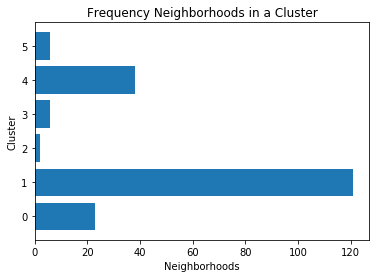

In [53]:
# Create horizontal bars
plt.barh(cluster_count["Cluster Labels"], cluster_count["Neighborhood"])
 
# Create names on the y-axis
#plt.yticks(y_pos, bars)

plt.title("Frequency Neighborhoods in a Cluster")
plt.ylabel("Cluster")
plt.xlabel("Neighborhoods")
# Show graphic
plt.show()

## Results and Discussion <a name="results"></a>